# load library

In [1]:
source("r/jupyter_common.R")

source("r/enrichment_analysis.R")
source("r/find_markers.R")
source("r/identify_cell_types.R")
source("r/plot_sc_clusters.R")


In [2]:
# data structure
suppressPackageStartupMessages(library(data.table))

# scRNA-seq
suppressPackageStartupMessages(library(Seurat))


# parameters

In [3]:
cancer_type <- "male-bc_er+bc-epi"

args <- list()
args$cancer_type <- cancer_type
args$method_to_identify_cell_types <- "singler_blueprint_encode"
args$harmony_theta <- 0

str_column_of_meta_data_harmony <- sprintf("RNA_harmony_th.%s", paste(args$harmony_theta, collapse=","))

str_reduction <- "pca"
str_umap_reduction <- "umap"  
col_cluster_types <- "cluster.type"

if (args$harmony_theta >= 0) {
    str_column_of_meta_data_cluster <- str_column_of_meta_data_harmony
    str_reduction <- "harmony"
    str_umap_reduction <- "umapharmony"
    col_cluster_types <- "cluster.type.harmony"
}

str_condition <- cancer_type

str_condition
str_column_of_meta_data_cluster
str_umap_reduction
col_cluster_types


figure_format <- "pdf"



[1] "male-bc_er+bc-epi"

[1] "RNA_harmony_th.0"

[1] "umapharmony"

[1] "cluster.type.harmony"

## set.seed

In [4]:
# set seed for reproducibility
set.seed(51)



## display

In [5]:
options(repr.matrix.max.cols=150, repr.matrix.max.rows=50)



# read scRNA-seq

In [6]:
dir_rna <- "/home/hkim77/francolab.w/sc-rna-seq/male-bc/run-20220725"
fname_rna <- sprintf("%s/output_male-bc/rds_er+bc/male-bc-epi_sc-rna-seq_merged_seurat_obj.rds", dir_rna)

rna <- readRDS(fname_rna)



# str_condition_tmp

In [7]:

sample1 <- "male-bc"
sample_ref <- "er+bc"

str_condition_tmp <- sprintf("%s_%s_vs_%s",
                             str_condition,
                             sample_ref, sample1)

str_condition_tmp


[1] "male-bc_er+bc-epi_er+bc_vs_male-bc"

# df_dge

In [8]:

filename <- "tsv/male-bc_er+bc-epi_er+bc_vs_male-bc.tsv"
df_dge <- read.table(filename, sep='\t', header=T, row.names=1)

head(df_dge)
dim(df_dge)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPS4Y1,1.655515e-174,2.313585,0.948,0.000,4.144417e-170,0,1.459589,2.984242
TNFRSF12A,3.075781e-164,2.987610,0.997,0.270,7.699909e-160,0,2.620978,4.394236
ISG20,3.978188e-146,2.525560,0.945,0.118,9.958995e-142,0,1.751471,3.843429
S100A6,2.320176e-145,3.401509,1.000,0.574,5.808329e-141,0,4.662926,6.206801
LGALS3,2.298172e-142,2.358381,0.997,0.445,5.753244e-138,0,2.710801,4.376743
SLC3A2,1.997836e-141,2.358616,0.995,0.296,5.001382e-137,0,2.079425,4.490780


[1] 1018    8

## down

In [9]:
f <- (df_dge$avg_log2FC < -1.0)
df_dge_dn <- df_dge[f,]
df_dge_dn


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XIST,9.451827e-80,-2.167863,0.000,0.552,2.366170e-75,0,0.000320396,0.8784898
FOS,1.816296e-78,-3.210594,0.129,0.700,4.546915e-74,0,0.118505794,4.7551218
TFF3,4.009161e-62,-3.649728,0.272,0.699,1.003653e-57,0,0.226063191,3.9290797
PBX1,1.079076e-41,-1.794105,0.228,0.552,2.701358e-37,0,0.132846291,1.8642010
HSPA1B,6.332088e-34,-1.860272,0.333,0.593,1.585175e-29,0,0.233527966,4.0261982


# df_dge.cse

In [10]:

filename <- "tsv/df_dge.cse.tsv"
df_dge.cse <- read.table(filename, sep='\t', header=T)

head(df_dge.cse)
dim(df_dge.cse)



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,expr_min,expr_mean,expr_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ISG20,3.978188e-146,2.525560,0.945,0.118,9.958995e-142,0.0000000,1.751471,3.843429
S100A6,2.320176e-145,3.401509,1.000,0.574,5.808329e-141,0.0000000,4.662926,6.206801
SAT1,8.599381e-139,2.803190,1.000,0.667,2.152769e-134,0.2981702,3.742109,5.598026
MYL12A,1.249291e-130,2.150761,0.998,0.570,3.127474e-126,0.0000000,2.650992,4.167212
PPP1R14B,8.975878e-129,1.897139,0.995,0.375,2.247021e-124,0.0000000,2.040378,3.449861
ANXA2,7.186044e-128,1.925806,0.999,0.668,1.798954e-123,0.0000000,2.983556,4.697529


[1] 363   8

## p2g_genes_female_vs_male.cse

In [11]:
f <- (abs(df_dge.cse$avg_log2FC) > 1.0 & df_dge.cse$p_val_adj < 0.01)
p2g_genes_female_vs_male.cse <- rownames(df_dge.cse[f,])
p2g_genes_female_vs_male.cse
print(length(p2g_genes_female_vs_male.cse))

if (length(p2g_genes_female_vs_male.cse) < 5) {
    p2g_genes_female_vs_male.cse <- rownames(df_dge.cse)
    print(p2g_genes_female_vs_male.cse)
    print(length(p2g_genes_female_vs_male.cse))
}


[1] "ISG20"    "S100A6"   "SAT1"     "MYL12A"   "PPP1R14B" "ANXA2"   
 [7] "MYL12B"   "TKT"      "HSPB8"    "S100A16"  "PIM3"     "NAA20"   
[13] "SH3BGRL3" "SQOR"     "FHL2"     "LAMB3"    "CAPN2"    "TALDO1"  
[19] "CLTB"     "PFKP"     "USP53"    "PHLDA2"   "SLC39A1"  "CD47"    
[25] "NDUFV2"   "PAWR"     "PPIF"     "BAG1"     "CSRP1"    "SLK"     
[31] "CLIP1"    "MYH9"     "C1QBP"    "MGLL"     "ZNF706"   "PHLDA3"  
[37] "PRDX4"    "S100A14"  "HES4"     "GNAS"     "SFN"      "VDAC2"   
[43] "GTF2A2"   "TMEM40"   "MGST1"    "FABP3"    "CCT3"     "FSTL3"   
[49] "METRN"    "TUBB4B"   "ACTN1"    "TACSTD2"  "FBXO32"   "SPTSSA"  
[55] "KRT23"    "GDF15"    "SERPINA1" "WFDC2"    "YWHAZ"    "KRT7"    
[61] "TPM1"

[1] 61


# heatmap

In [12]:
rna$cluster.type.doheatmap <- "Male BC"
f <- grepl("ER_", rna$Sample)
rna$cluster.type.doheatmap[f] <- "Female BC"
head(rna$cluster.type.doheatmap)

ER_MH0001#AAACCTGCAGGGATTG-1 ER_MH0001#AAACCTGGTCAGGACA-1 
                 "Female BC"                  "Female BC" 
ER_MH0001#AAACCTGTCCGTAGTA-1 ER_MH0001#AAACGGGAGCCACGCT-1 
                 "Female BC"                  "Female BC" 
ER_MH0001#AAACGGGAGCTGTCTA-1 ER_MH0001#AAAGATGTCAACGCTA-1 
                 "Female BC"                  "Female BC"

## nv_colors_type

In [13]:
mypal <- ggsci::pal_npg("nrc", alpha=0.7)(9)
nv_colors_type <- c("Female BC"=mypal[1], "Male BC"=mypal[2])


## plot_heatmap

In [14]:

list_out <- plot_heatmap(dataset = rna,
        markers = c(rownames(df_dge_dn), p2g_genes_female_vs_male.cse),
        sort_var = c("cluster.type.doheatmap", col_cluster_types),
        anno_var = c("cluster.type.doheatmap"),
        anno_colors = list(nv_colors_type, "Set1", "Reds"),
        anno_name = c("type", "", ""),
        list_annotation_legend_param = list(type=list(title="", ncol=2)),
        heatmap_legend_param = list(direction = "horizontal", legend_width = unit(6, "cm"), title = "Expression"),
        simple_anno_size=unit(0.75, "cm"),
        hm_limit = c(-2, 0, 2),
        hm_colors = c("#ff00ff","black","#ffff00"),
        row_font_size = 13
    )           



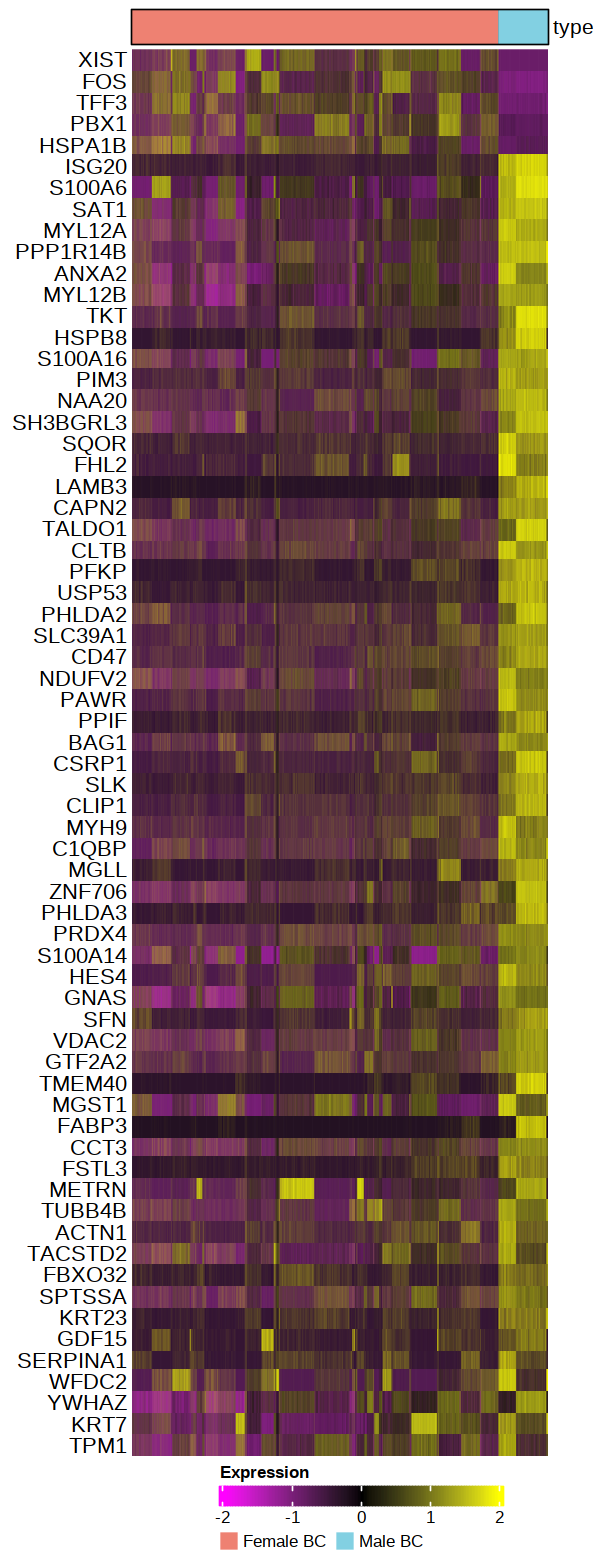

In [15]:
print_figure(list_out$list_ht, width=5, height=13,
    file=sprintf("heatmap_%s", str_condition_tmp),
    heatmap_legend_side="bottom",
    figure_format_=figure_format,
    resolution=300)


# session info

In [16]:
writeLines(capture.output(sessionInfo()), "txt/sessionInfo.txt")


# reference

https://satijalab.org/seurat/

